# Natural Language Processing and Starbucks Reviews

## Deep Learning Problem 
This project analyzes some review data from Starbucks, which is a popular coffee chain. The project performs Natural Language Processing (NLP) analyses on the text of written reviews and classifies the resulting rating. The project will implement CNN and RNN algorithms and evaluate their performances. 

+ Github Link: https://github.com/mcdatbuff/DeepLearning-Starbucks/upload

## Exploratory Data Analysis (EDA)

### **Data**
There is one data file, reviews_data.csv that was obtained from [Kaggle](https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset/data). The data is tabular and contains 6 features
+ feature descriptions:
    + name- name of reviewer 
    + location- location of reviewer 
    + Date- date of review
    + Rating- rating given by reviewer, ranked 1-5
    + Review- review text containing thoughts and opinions 
    + Image_Links- links to images related to reviews

In [417]:
# import packages 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,GRU,Conv1D, GlobalMaxPooling1D

+ Data Inspection
    + 6 columns with 850 rows 
    + all data types are objects, except for Rating, which is integer

In [418]:
# import dataset 
df = pd.read_csv('reviews_data.csv')
# display top of dataframe
display(df.head())
# display information about data
display(df.info())

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


None

+ Check for null values 
    + Calculated the sum of null values for each column. There were 145 missing Ratings, so they were removed since Rating is the target variable: 

In [419]:
# Check for Null Values
print("Null Values Before:")
print(df.isna().sum())
# Remove Null Values
df = df.dropna()
print(" ")
print("Null Values After:")
print(df.isna().sum())

Null Values Before:
name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64
 
Null Values After:
name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
dtype: int64


+ **Display Ratings Distribution**

There is a higher proportion of negative reivews (1) to positive (5). This could be expected, since generally people only take time to write reviews after a memorable negative experience. 

Text(0.5, 0, 'Count')

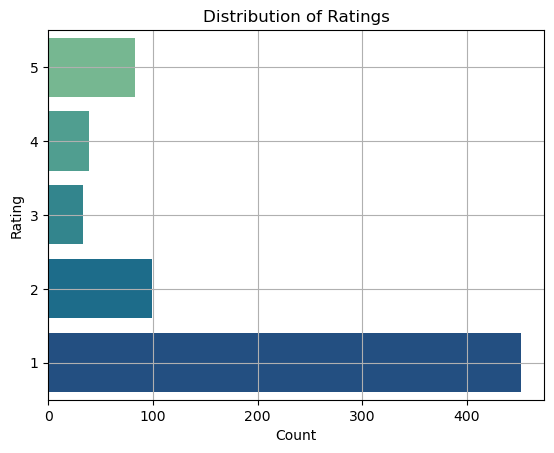

In [420]:
# Seaborn countplot 
sns.countplot(data=df, y='Rating', palette='crest', 
              saturation=1, order=[5, 4, 3, 2, 1])
plt.grid()
plt.title("Distribution of Ratings")
plt.xlabel("Count")

+ **Date Distribution**

A new year column was created and plotted to view the distribution of years that each review was made. Reviews range from 2010-2023, wtih the majority coming from 2017. 

Text(0, 0.5, 'Count')

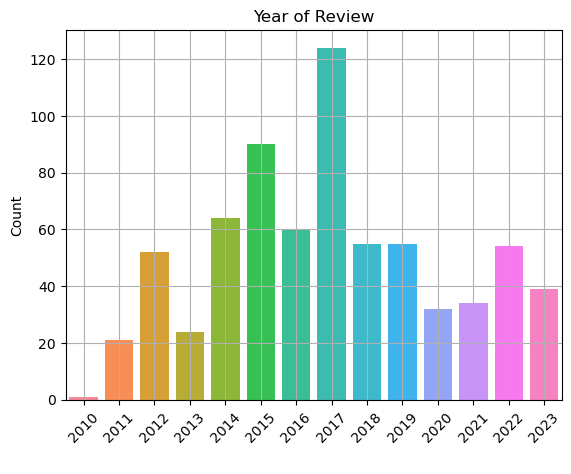

In [421]:
# Extract year from Date column
df['Year'] = df['Date'].str.split(",").str[1]
# Convert Year column to numeric
df['Year'] = pd.to_numeric(df['Year'])
# Seaborn countplot
yrplot = sns.countplot(data=df, x='Year', 
              saturation=1)
yrplot.set_xticklabels(yrplot.get_xticklabels(), rotation=45)
plt.grid()
plt.title("Year of Review")
plt.xlabel(" ")
plt.ylabel("Count")

+ **Correlations of Numeric Data**
    + There is not a strong correlation between rating and year. The other variables are categorical and not applicable.

,Rating,Year
Rating,1.000000,0.053304
Year,0.053304,1.000000


<AxesSubplot:>

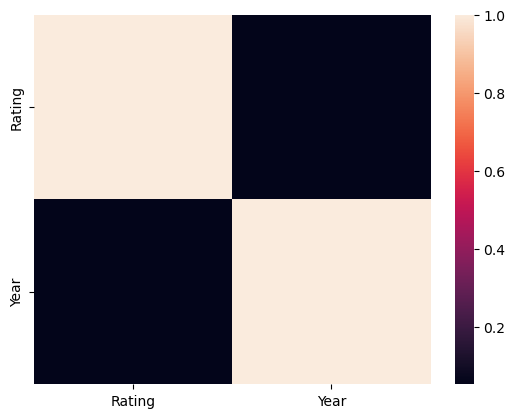

In [422]:
corr = df.corr()
display(corr)
display(sns.heatmap(corr))

+ **Data Preprocessing** 
    + Added two new categorical columns. The NewRating column provides numerical values, matching values above 3 as positive, equal to 3 as neutral, and less than 3 negative. The Category column provides string categories to those values. 

In [423]:
# New Column- Positive=0, Neutral=1, Negative=2
def f(row):
    if row['Rating'] > 3:
        val = 0
    elif row['Rating'] == 3:
        val = 1
    elif row['Rating'] < 3:
        val = 2
    return val

df['NewRating'] = df.apply(f, axis=1)

In [424]:
# New Column - Positve, Neutral or Negative
def f(row):
    if row['NewRating'] == 0:
        val = 'Positive'
    elif row['NewRating'] == 1:
        val = 'Neutral'
    elif row['NewRating'] == 2:
        val = 'Negative'
    return val

df['Category'] = df.apply(f, axis=1)

+ **Distribution of Experience: Positive, Neutral, or Negative** 
    + Using the new categories, calculated the percentage of each type of experience and plotted below. The neutral category is the smallest at 4.68%. 

In [425]:
total = df['Category'].count()
print("Balance of Categries: ")
round(((df.Category.value_counts()/total)*100),2)

Balance of Categries: 


Negative    78.01
Positive    17.30
Neutral      4.68
Name: Category, dtype: float64

Text(1.99, 50, '4.68%')

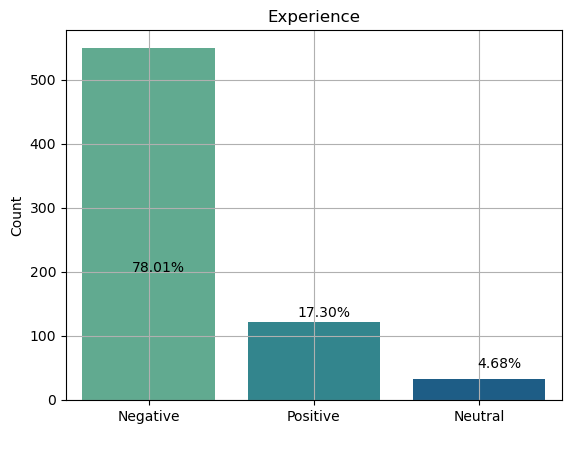

In [426]:
sns.countplot(data=df, x='Category', palette='crest', saturation=1, 
             order = df['Category'].value_counts().index)
plt.grid()
plt.title("Experience")
plt.ylabel("Count")
plt.xlabel(" ")
plt.text(-0.1, 200, '78.01%')
plt.text(0.9, 130, '17.30%')
plt.text(1.99, 50, '4.68%')

+ **Visualizing the Review Text** 
    + Below is an example of one review and the type of text present. 
    + The chart calculated the length of each review, and displays the distribution of text length by experience category. The negative reivews have a more normal distribution, while positive ones appear more exponential.

In [427]:
df['Review'][10]

"I filed a BBB complaint last month because Starbucks canceled my Starbucks Reward cards. I couldn't remember the balances, so I guessed about $9. Starbucks played nothing but games and tried everything they could to avoid responding to the complaint. I received a couple of phone call messages asking me to contact them directly and discuss the matter. The number provided was the customer service number and when I spoke with one representative, Linda hung up the phone on me. I did not use my card since 2012 which is my prerogative. Because of this and other reasons, Starbucks decided to close my Starbucks account. I reopened one about a few weeks ago and added a new card that I have not used yet."

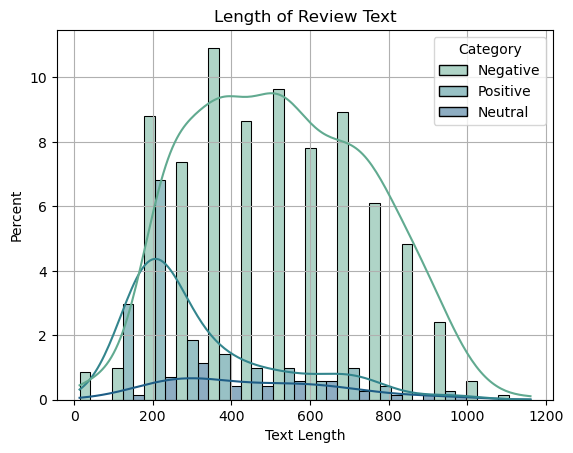

In [428]:
wordcount = df.copy()
wordcount['Text Length'] = wordcount['Review'].apply(len)
wordcount = wordcount.sort_values(by=['Text Length'], ascending=False)
sns.histplot(data=wordcount, x='Text Length', hue='Category', stat='percent',
            palette='crest', multiple='dodge',kde=True)
plt.title('Length of Review Text')
plt.grid()

### **Data Processing and Transformation**
+ Removed name, location, Date and Image_Links columns since they will not be used for the model analysis. 

In [429]:
df = df.drop(columns=['name', 'location', 'Date', 'Image_Links'], axis=1)
df.head()

,Rating,Review,Year,NewRating,Category
0,5.0,Amber and LaDonna at the Starbucks on Southwes...,2023,0,Positive
1,5.0,** at the Starbucks by the fire station on 436...,2023,0,Positive
2,5.0,I just wanted to go out of my way to recognize...,2023,0,Positive
3,5.0,Me and my friend were at Starbucks and my card...,2023,0,Positive
4,5.0,I’m on this kick of drinking 5 cups of warm wa...,2023,0,Positive


+ Cleaned the Review text data by making the text lowercase, removing numbers and punctuation, and removing extra spaces between words: 

In [430]:
# make lowercase
df['Review'] = df['Review'].str.lower()
# remove numbers
df['Review'] = df['Review'].apply(lambda row: re.sub(r'[0-9]+', '', row))
# remove punctuation
df['Review'] = df['Review'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
# remove extra spaces
df['Review'] = df['Review'].apply(lambda row: re.sub(r'\s+', ' ', row))

+ Display cleaned text: 

In [431]:
df['Review'][10]

'i filed a bbb complaint last month because starbucks canceled my starbucks reward cards i couldnt remember the balances so i guessed about starbucks played nothing but games and tried everything they could to avoid responding to the complaint i received a couple of phone call messages asking me to contact them directly and discuss the matter the number provided was the customer service number and when i spoke with one representative linda hung up the phone on me i did not use my card since which is my prerogative because of this and other reasons starbucks decided to close my starbucks account i reopened one about a few weeks ago and added a new card that i have not used yet'

* Split data into an 80/20 train/test split. NewRating (0-2) is the target. Tokenized and added padding to the split data. The padding adds extra tokens to short sequences and make them the same length.  

In [432]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(df['Review'],
                                                    df['NewRating'], 
                                                    test_size=0.2, 
                                                    random_state=123)

In [433]:
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)
# Padding
Xtrain = pad_sequences(X_train_seq)
Xval = pad_sequences(X_val_seq)

# Model Analysis

### CNN Model
+ A convolutional neural network (CNN) was the first model used. The model has an embedding layer and two dense layers with relu and softmax with 3 outcomes. The convolutional layer has 64 filters and a 3 for kernel size. A max pooling layer was added to calculate max values in the feature. Sparse categorical crossentropy was used to match the most likely category (0, 1, 2). Adam optimizer was used.

In [452]:
model = Sequential()
model.add(Embedding(30000,64))
model.add(Dense(units=256, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=3, activation='softmax'))
optm = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [435]:
# Fit Model
history = model.fit(Xtrain, y_train, epochs=10, validation_data=(Xval, y_test))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6710 - loss: 0.9161 - val_accuracy: 0.7589 - val_loss: 0.7388
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7835 - loss: 0.6167 - val_accuracy: 0.7589 - val_loss: 0.6506
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7656 - loss: 0.6046 - val_accuracy: 0.7589 - val_loss: 0.6349
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7719 - loss: 0.5923 - val_accuracy: 0.7589 - val_loss: 0.5891
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7703 - loss: 0.5170 - val_accuracy: 0.7589 - val_loss: 0.5642
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8033 - loss: 0.4399 - val_accuracy: 0.8014 - val_loss: 0.5211
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8670 - loss: 0.3354 - val_accuracy: 0.8085 - val_loss: 0.4813
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9122 - loss: 0.2476 - val_accuracy: 0.8298 - v

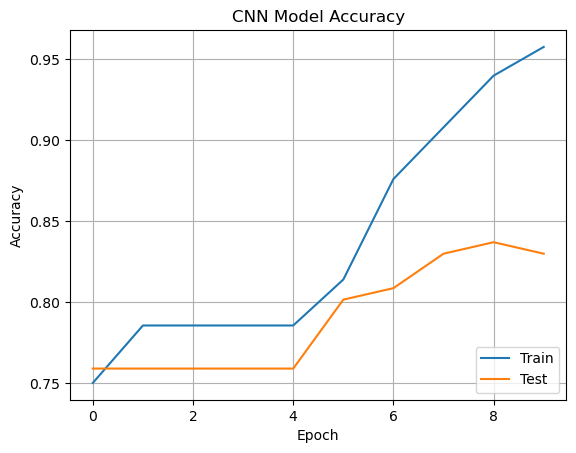

In [436]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid()
plt.show()

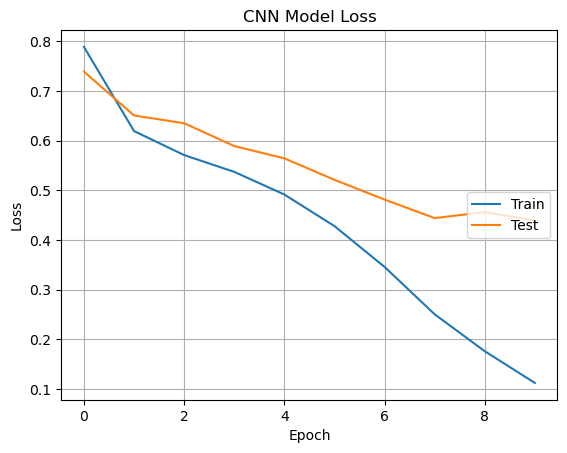

In [437]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.grid()
plt.show()

### RNN- LSTM Model
+ A Long Short Term Memory (LSTM) model was the second model used. LSTM is a type of recurrent neural network (RNN) that remvoes the vanishing gradient problem. The model has an embedding layer and one dense layer with softmax. The lstm layer has 16 units. A max pooling layer was added to calculate max values in the feature. Sparse categorical crossentropy was used to match the most likely category (0, 1, 2). Adam optimizer was used.

In [446]:
model2 = Sequential()
model2.add(Embedding(30000, 64))
model2.add(LSTM(50, return_sequences=True))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(3, activation='softmax'))
optm = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [447]:
history2 = model2.fit(Xtrain, y_train, epochs=10, validation_data=(Xval, y_test))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7228 - loss: 0.9168 - val_accuracy: 0.7589 - val_loss: 0.7156
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7580 - loss: 0.7155 - val_accuracy: 0.7589 - val_loss: 0.6618
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7716 - loss: 0.6323 - val_accuracy: 0.7589 - val_loss: 0.6256
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7781 - loss: 0.5670 - val_accuracy: 0.7589 - val_loss: 0.5804
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7642 - loss: 0.5578 - val_accuracy: 0.8440 - val_loss: 0.4801
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9108 - loss: 0.3476 - val_accuracy: 0.8582 - val_loss: 0.4584
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9243 - loss: 0.3009 - val_accuracy: 0.8369 - val_loss: 0.5249
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9125 - loss: 0.3228 - val_accuracy: 0.8440 - v

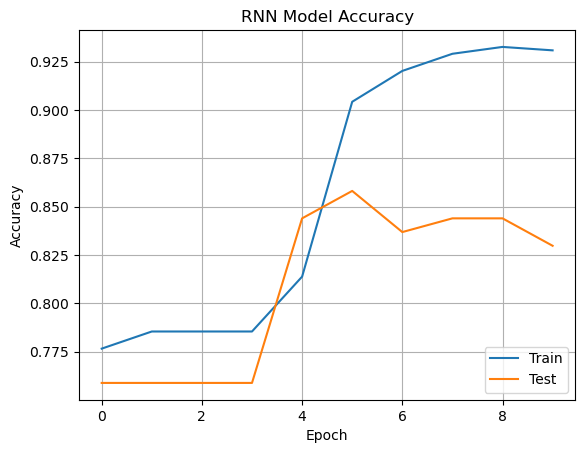

In [448]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid()
plt.show()

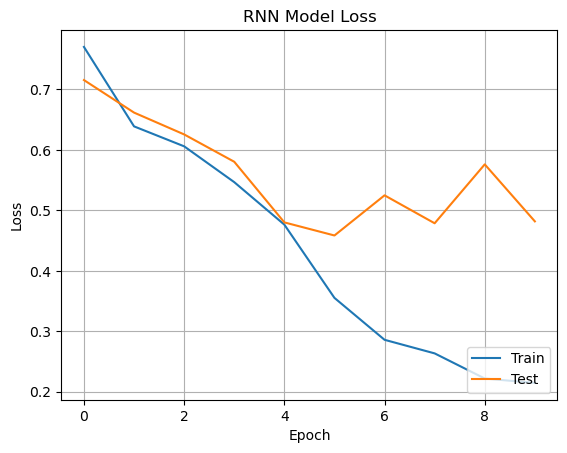

In [449]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid()
plt.show()

### Model Comparison
The CNN performed slightly better with an accuracy of 0.9574. Hyperparameter optimation will be done to see if the performance can be improved.  

In [458]:
print("CNN Accuracy:", history.history['accuracy'][-1])
print("LSTM Accuracy:", history2.history['accuracy'][-1])

CNN Accuracy: 0.957446813583374
LSTM Accuracy: 0.9308510422706604


### Hyperparameter Optimization 
* First try decreasing the Dense filter value to 128- this did not improve accuracy.

In [473]:
model3 = Sequential()
model3.add(Embedding(30000,64))
model3.add(Dense(units=128, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(units=3, activation='softmax'))
optm = optimizers.Adam(learning_rate=0.001)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [474]:
history3 = model3.fit(Xtrain, y_train, batch_size=32, epochs=10, validation_data=(Xval, y_test))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7549 - loss: 0.8451 - val_accuracy: 0.7589 - val_loss: 0.6814
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7555 - loss: 0.6741 - val_accuracy: 0.7589 - val_loss: 0.6296
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7980 - loss: 0.5507 - val_accuracy: 0.7589 - val_loss: 0.5997
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7892 - loss: 0.5109 - val_accuracy: 0.7589 - val_loss: 0.5670
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8098 - loss: 0.4552 - val_accuracy: 0.8014 - val_loss: 0.5241
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8476 - loss: 0.4279 - val_accuracy: 0.8085 - val_loss: 0.4856
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8747 - loss: 0.3521 - val_accuracy: 0.8156 - val_loss: 0.4526
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9065 - loss: 0.3121 - val_accuracy: 0.8369 - v

In [475]:
print("CNN 1 Accuracy:", history.history['accuracy'][-1])
print("CNN 2 Accuracy:", history3.history['accuracy'][-1])

CNN 1 Accuracy: 0.957446813583374
CNN 2 Accuracy: 0.9414893388748169


* Next, try increasing the learning rate slightly from 0.001 to 0.005. This bumped accuracy up to 0.99. This likely caused the model to converge too quickly and is probably not the best choice. 

In [476]:
model4 = Sequential()
model4.add(Embedding(30000,64))
model4.add(Dense(units=128, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(units=3, activation='softmax'))
optm = optimizers.Adam(learning_rate=0.005)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [477]:
history4 = model4.fit(Xtrain, y_train, batch_size=64, epochs=10, validation_data=(Xval, y_test))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7638 - loss: 0.8098 - val_accuracy: 0.7589 - val_loss: 0.6456
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7919 - loss: 0.5804 - val_accuracy: 0.7589 - val_loss: 0.5539
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8198 - loss: 0.4802 - val_accuracy: 0.8085 - val_loss: 0.4941
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8732 - loss: 0.4019 - val_accuracy: 0.8369 - val_loss: 0.4518
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8774 - loss: 0.3574 - val_accuracy: 0.8652 - val_loss: 0.4093
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9431 - loss: 0.2162 - val_accuracy: 0.8369 - val_loss: 0.4114
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9571 - loss: 0.1355 - val_accuracy: 0.8582 - val_loss: 0.4045
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9924 - loss: 0.0647 - val_accuracy: 0.8511 - val_loss: 0.4697


In [478]:
print("CNN 1 Accuracy:", history.history['accuracy'][-1])
print("CNN 2 Accuracy:", history3.history['accuracy'][-1])
print("CNN 3 Accuracy:", history4.history['accuracy'][-1])

CNN 1 Accuracy: 0.957446813583374
CNN 2 Accuracy: 0.9414893388748169
CNN 3 Accuracy: 1.0


# Conclusions and Results
Based on the results, the model of choice would be the original CNN model. This model performed well as it depended on review text and not necessarily the sequence and performed well for classification. While the higher learning rate model reached accuracy of 1.0, it likely converged too early and wasn't the best solution. Some further analysis would be helpful to study some other models, such as BERT. It would also be interesting to incorporate some traditonal machine learning techniques, such logistic regression or naive bayes classification. 

In [479]:
print("CNN 1 Accuracy:", history.history['accuracy'][-1])
print("RNN Accuracy:", history2.history['accuracy'][-1])
print("CNN2 Accuracy:", history3.history['accuracy'][-1])
print("CNN3 Accuracy:", history4.history['accuracy'][-1])

CNN 1 Accuracy: 0.957446813583374
RNN Accuracy: 0.9308510422706604
CNN2 Accuracy: 0.9414893388748169
CNN3 Accuracy: 1.0


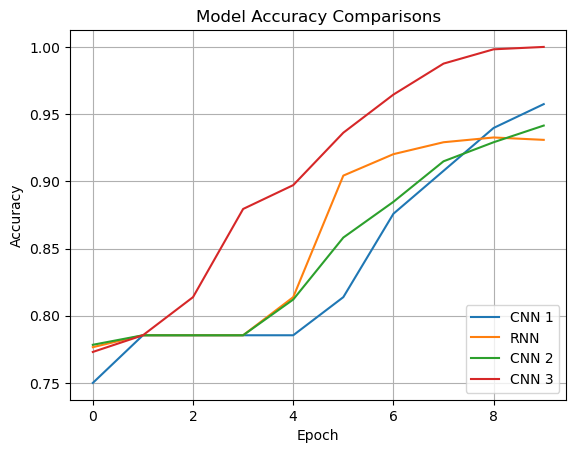

In [480]:
plt.plot(history.history['accuracy'], label='CNN 1')
plt.plot(history2.history['accuracy'], label='RNN')
plt.plot(history3.history['accuracy'], label='CNN 2')
plt.plot(history4.history['accuracy'], label='CNN 3')
plt.title('Model Accuracy Comparisons')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()